<a href="https://colab.research.google.com/github/Kaproc/proyecto-inundaciones-Grupo-2/blob/main/Aprendizaje_Automatico_Proyecto_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)


Descargar archivos desde el drive

In [ ]:
!pip -q install gdown

import pandas as pd

# Descargar carpeta completa
!gdown --folder "https://drive.google.com/drive/folders/1Wkz2Tg6ViSVGZSRm9zi6_xrk1N8_czHm" -O datos

# Cargar los 3 archivos requeridos
base = "/content/datos"

df = pd.read_excel(f"{base}/Base_Eventos_2010_2023_eventos_catálogo.xlsx", sheet_name="Base20102022")
df_clima = pd.read_csv(f"{base}/ecu-rainfall-subnat-full.csv")
df_postal = pd.read_excel(f"{base}/LISTADO-CODIGOS-POSTALES.xlsx", sheet_name="Hoja1")


Retrieving folder contents
Processing file 1uhsaaosMsR_hkylLdJ_wOACFyHHsjaF- Base_Eventos_2010_2023_eventos_catálogo.xlsx
Processing file 16yQAp8HblCzhwY1obaI8s2YHEp8KCCGD ecu-rainfall-subnat-full.csv
Processing file 1oG_kuwknf-V9XlgBX46FRzigvTTOpzzq LISTADO-CODIGOS-POSTALES.xlsx
Processing file 1u8uvcR8Mf5U3bXqbu8Qv2wiKJuhilCbJ ORGANIZACION TERRITORIAL DEL ESTADO PARROQUIAL (1).json
Processing file 1SCXge-S1Ov0mvQjAh36c8VdG8lh1I5v5 ORGANIZACION TERRITORIAL DEL ESTADO PARROQUIAL.shp
Processing file 1oBLdLOrhf78O67jmmSOu_45UZg1LWtFK predicciones_modelo_final_con_id.csv
Processing file 1i5s18x6I-TKmvLjDIiyjrpKH3LD9Q54Y predicciones_modelo_final.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1uhsaaosMsR_hkylLdJ_wOACFyHHsjaF-
To: /content/datos/Base_Eventos_2010_2023_eventos_catálogo.xlsx
100% 29.4M/29.4M [00:00<00:00, 85.3MB/s]
Downloading...
From: https://drive.google.com/uc?

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Leer archivos localmente

In [ ]:
base = '/content/datos'
df = pd.read_excel(f'{base}/Base_Eventos_2010_2023_eventos_catálogo.xlsx', sheet_name='Base20102022')
df_clima = pd.read_csv(f'{base}/ecu-rainfall-subnat-full.csv')
df_postal = pd.read_excel(f'{base}/LISTADO-CODIGOS-POSTALES.xlsx', sheet_name='Hoja1')

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# **Origen y preparación de los datos**

Para el desarrollo del proyecto se integraron tres fuentes de datos principales:

**Base de eventos históricos (2010–2023)**

Contiene registros oficiales de eventos adversos en Ecuador, incluyendo información espacial (provincia, cantón, parroquia), temporal (fecha, año, mes) y de impacto humano (personas afectadas, damnificadas y fallecidas).
De esta base se filtraron únicamente los eventos cuya causa fue la lluvia y cuyo tipo de evento corresponde a inundaciones.

Camacho, C. (2023). Eventos de inundación de Ecuador 2010-2023, HydroShare, http://www.hidroshare.org/resource/e7a4a44bed0d408b958b682b8fa237c3

**Dataset climático de precipitación**

Proporciona información histórica de precipitación a nivel subnacional, identificada mediante códigos territoriales oficiales (PCODE).
A partir de este dataset se utilizó la precipitación promedio histórica a nivel cantonal.
https://data.humdata.org/dataset/ecu-rainfall-subnational

**Dataset administrativo–poblacional**

Incluye la división político-administrativa del país y datos de población.
La población fue agregada a nivel cantonal para mantener consistencia con el nivel territorial del análisis climático.

https://regulacion.mintel.gob.ec/descargue-productos-del-sistema-codigo-postal-ecuatoriano/

Todos los datasets fueron limpiados eliminando valores faltantes en variables clave, corrigiendo formatos y evitando duplicaciones derivadas del cruce de información.

In [ ]:
df

,IDBASEANT,ID,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,COMUNIDAD/BARRIO/SECTOR,LATITUD,...,Personas Impactadas,CODIFICACION PROVINCIAL-VAL,CANTON-VAL,CODIFICACION CANTONAL-VAL,PARROQUIAS-VAL,CODIFICACION PARROQUIAL-VAL,LATITUD-VAL,LONGITUD-VAL,val,AGROPECUARIA
0,1.0,1.0,Azuay,1,Cuenca,101,Molleturo,10157,"Tanzaray, Chacanseo",-2.717509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2.0,2.0,Azuay,1,Santa Isabel,108,Santa Isabel (Chaguarurco),10850,Vía Santa Isabel - Pasaje,-3.288058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,3.0,3.0,Azuay,1,Sevilla De Oro,113,Amaluza,11351,vía Guarumales - Méndez km15,-2.596527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,4.0,4.0,Azuay,1,Cuenca,101,Victoria Del Portete (Irquis),10171,"Altarloma, Sombrederas, Duraznos",-3.071833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,5.0,5.0,Azuay,1,Nabon,104,Nabon,10450,Nabón,-3.337235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
61026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
61027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
61028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
print(df.columns)

Index(['IDBASEANT', 'ID', 'PROVINCIA', 'CODIFICACION PROVINCIAL', 'CANTON',
       'CODIFICACION CANTONAL', 'PARROQUIAS', 'CODIFICACION PARROQUIAL',
       'COMUNIDAD/BARRIO/SECTOR', 'LATITUD', 'LONGITUD', 'EVENTO', 'CAUSA',
       'CATEGORIA DEL EVENTO', 'FECHA DEL EVENTO', 'MES', 'HORA DEL EVENTO',
       'FECHA DEL INFORME ', 'NUMERO DE INFORME NACIONAL',
       'CODIDO RED MONITOREO', 'NUMERO DE INFORME PROVINCIAL', 'FALLECIDAS',
       'HERIDAS', 'PERSONAS DESAPARECIDAS', 'FAMILIAS AFECTADAS',
       'PERSONAS AFECTADAS DIRECTAMENTE', 'AFECTADAS INDIRECTAS',
       'FAMILIAS DAMNIFICADAS', 'PERSONAS DAMNIFICADAS', 'PERSONAS EVACUADAS',
       'PERSONAS ALBERGADAS', 'P. EN FAMILIAS ACOGIENTES',
       'PERSONAS EN\n  OTROS MEDIOS', 'PERSONAS EN PROCESO DE EVACUACION',
       'PERSONAS QUE RESISTEN A LA EVACUACION', 'VIVIENDAS AFECTADAS',
       'VIVIENDAS DESTRUIDAS', 'ESTABLECIMIENTOS EDUCATIVOS AFECTADOS',
       'ESTABLECIMIENTOS EDUCATIVOS DESTRUIDOS', 'CENTROS DE SALUD AFECTAD

In [ ]:
df = df[df['CAUSA'].str.contains('lluv', case=False, na=False)]


In [ ]:
df['CAUSA'].value_counts()


,count
CAUSA,
Lluvias,15398


In [ ]:
df['CAUSA'].unique()


array(['Lluvias'], dtype=object)

In [ ]:
df

,IDBASEANT,ID,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,COMUNIDAD/BARRIO/SECTOR,LATITUD,...,Personas Impactadas,CODIFICACION PROVINCIAL-VAL,CANTON-VAL,CODIFICACION CANTONAL-VAL,PARROQUIAS-VAL,CODIFICACION PARROQUIAL-VAL,LATITUD-VAL,LONGITUD-VAL,val,AGROPECUARIA
0,1.0,1.0,Azuay,1,Cuenca,101,Molleturo,10157,"Tanzaray, Chacanseo",-2.717509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2.0,2.0,Azuay,1,Santa Isabel,108,Santa Isabel (Chaguarurco),10850,Vía Santa Isabel - Pasaje,-3.288058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,10.0,10.0,Azuay,1,Gualaceo,103,Jadan,10353,Tocteloma,-2.888019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
11,12.0,12.0,Azuay,1,Cuenca,101,Llacao,10156,La Unión,-2.844229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
12,13.0,13.0,Azuay,1,Chordeleg,111,La Union,11152,Zhucus,-2.925302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51540,NaN,51542.0,Zamora Chinchipe,19,Zamora,1901,Guadalupe,190152,"San Antonio, vía Guadalupe _Yacuambi [E50]",-3.920829,...,NaN,19.0,Zamora,1901.0,Guadalupe,190152.0,-3.920829,-78.951037,#REF!,0.0
51541,NaN,51543.0,Zamora Chinchipe,19,Zamora,1901,Sabanilla,190155,"El Destrozo, Vía Loja- Zamora [E50]",-4.040339,...,NaN,19.0,Zamora,1901.0,Sabanilla,190155.0,-4.040339,-79.013407,#REF!,0.0
51542,NaN,51544.0,Zamora Chinchipe,19,Zamora,1901,Sabanilla,190155,"El Tambo, vía – Zamora - Loja E50",-3.950717,...,NaN,19.0,Zamora,1901.0,Sabanilla,190155.0,-3.950717,-79.046733,#REF!,0.0
51543,NaN,51545.0,Zamora Chinchipe,19,Palanda,1908,Palanda,190850,"Numbala, vía San Francisco del Vergel- Numbala...",-4.659145,...,NaN,19.0,Palanda,1908.0,Palanda,190850.0,-4.659145,-79.233534,#REF!,0.0


In [ ]:
columnas_utiles = [
    'PROVINCIA',
    'CODIFICACION PROVINCIAL',
    'CANTON',
    'CODIFICACION CANTONAL',
    'PARROQUIAS',
    'CODIFICACION PARROQUIAL',
    'LATITUD',
    'LONGITUD',
    'EVENTO',
    'CATEGORIA DEL EVENTO',
    'CAUSA',
    'FECHA DEL EVENTO',
    'AÑO',
    'MES',
    'PERSONAS AFECTADAS DIRECTAMENTE',
    'PERSONAS DAMNIFICADAS',
    'FAMILIAS AFECTADAS',
    'FALLECIDAS'
]


In [ ]:
df = df[columnas_utiles]

In [ ]:
df = df[df['EVENTO'].str.contains('inund', case=False, na=False)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4182 entries, 0 to 51523
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   PROVINCIA                        4182 non-null   object        
 1   CODIFICACION PROVINCIAL          4182 non-null   object        
 2   CANTON                           4182 non-null   object        
 3   CODIFICACION CANTONAL            4182 non-null   object        
 4   PARROQUIAS                       4182 non-null   object        
 5   CODIFICACION PARROQUIAL          4182 non-null   object        
 6   LATITUD                          4182 non-null   float64       
 7   LONGITUD                         4182 non-null   float64       
 8   EVENTO                           4182 non-null   object        
 9   CATEGORIA DEL EVENTO             4182 non-null   object        
 10  CAUSA                            4182 non-null   object        


In [ ]:
df

,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,LATITUD,LONGITUD,EVENTO,CATEGORIA DEL EVENTO,CAUSA,FECHA DEL EVENTO,AÑO,MES,PERSONAS AFECTADAS DIRECTAMENTE,PERSONAS DAMNIFICADAS,FAMILIAS AFECTADAS,FALLECIDAS
0,Azuay,1,Cuenca,101,Molleturo,10157,-2.717509,-79.397208,INUNDACIÓN,Época Lluviosa,Lluvias,2010-03-18,2010.0,3.0,750.0,0.0,187.5,0.0
31,Bolívar,2,Las Naves,207,Las Naves,20702,-1.286872,-79.292168,INUNDACIÓN,Época Lluviosa,Lluvias,2010-03-02,2010.0,3.0,0.0,0.0,0.0,0.0
36,Bolívar,2,Echeandía,204,Echeandia,20450,-1.473707,-79.312869,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-03,2010.0,4.0,100.0,0.0,25.0,0.0
39,Bolívar,2,San Miguel,205,San Miguel,20550,-1.722491,-79.051502,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0
40,Bolívar,2,San Miguel,205,Regulo De Mora,20553,-1.884385,-79.202489,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51517,Zamora Chinchipe,19,Centinela Del Cóndor,1907,Triunfo-Dorado,190752,-3.935038,-78.704581,INUNDACIÓN,Época Lluviosa,Lluvias,2021-11-02,2021.0,11.0,60.0,0.0,20.0,0.0
51520,Zamora Chinchipe,19,Chinchipe,1902,Zumba,190250,-4.859691,-79.133198,INUNDACIÓN,Época Lluviosa,Lluvias,2021-11-16,2021.0,11.0,16.0,0.0,4.0,0.0
51521,Zamora Chinchipe,19,Yantzaza,1905,Los Encuentros,190553,-3.761991,-78.653250,INUNDACIÓN,Época Lluviosa,Lluvias,2021-11-16,2021.0,11.0,7.0,0.0,2.0,0.0
51522,Zamora Chinchipe,19,Nangaritza,1903,Guayzimi,190350,-4.053117,-78.681305,INUNDACIÓN,Época Lluviosa,Lluvias,2021-11-17,2021.0,11.0,0.0,0.0,3.0,0.0


In [ ]:
df['pcode_canton'] = (
    'EC' + df['CODIFICACION CANTONAL'].astype(str).str.zfill(4)
)

In [ ]:
df_clima_canton = (
    df_clima[df_clima['adm_level'] == 2]
    .groupby('PCODE', as_index=False)['rfh_avg']
    .mean()
    .rename(columns={'rfh_avg': 'precipitacion_promedio_mm'})
)

In [ ]:
df_postal_limpio = df_postal[
    ['dpa_provin', 'dpa_despro', 'dpa_canton', 'dpa_descan', 'Poblacion']
].dropna()

df_postal_limpio['pcode_canton'] = (
    'EC' + df_postal_limpio['dpa_canton'].astype(str).str.zfill(4)
)

In [ ]:
df_postal_canton = (
    df_postal_limpio
    .groupby('pcode_canton', as_index=False)
    .agg({
        'dpa_provin': 'first',
        'dpa_despro': 'first',
        'dpa_canton': 'first',
        'dpa_descan': 'first',
        'Poblacion': 'sum'
    })
)

In [ ]:
df.head()

,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,LATITUD,LONGITUD,EVENTO,CATEGORIA DEL EVENTO,CAUSA,FECHA DEL EVENTO,AÑO,MES,PERSONAS AFECTADAS DIRECTAMENTE,PERSONAS DAMNIFICADAS,FAMILIAS AFECTADAS,FALLECIDAS,pcode_canton
0,Azuay,1,Cuenca,101,Molleturo,10157,-2.717509,-79.397208,INUNDACIÓN,Época Lluviosa,Lluvias,2010-03-18,2010.0,3.0,750.0,0.0,187.5,0.0,EC0101
31,Bolívar,2,Las Naves,207,Las Naves,20702,-1.286872,-79.292168,INUNDACIÓN,Época Lluviosa,Lluvias,2010-03-02,2010.0,3.0,0.0,0.0,0.0,0.0,EC0207
36,Bolívar,2,Echeandía,204,Echeandia,20450,-1.473707,-79.312869,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-03,2010.0,4.0,100.0,0.0,25.0,0.0,EC0204
39,Bolívar,2,San Miguel,205,San Miguel,20550,-1.722491,-79.051502,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0,EC0205
40,Bolívar,2,San Miguel,205,Regulo De Mora,20553,-1.884385,-79.202489,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0,EC0205


# **Selección de las variables predictoras**

Las variables seleccionadas como características del modelo fueron:

**-precipitacion_promedio_mm**

Variable derivada que representa la precipitación promedio histórica por cantón.
Se seleccionó debido a que la intensidad y recurrencia de lluvias es un factor determinante en la ocurrencia de inundaciones.

**-Poblacion_Cantonal**

Representa la población total del cantón.
Esta variable se incluyó como un indicador de exposición y vulnerabilidad, ya que cantones con mayor población tienden a presentar un mayor impacto humano ante eventos de inundación.

In [ ]:
df = df.merge(
    df_clima_canton,
    left_on='pcode_canton',
    right_on='PCODE',
    how='left'
)
df = df.drop(columns=['PCODE'])

In [ ]:
df = df.merge(
    df_postal_canton,
    on='pcode_canton',
    how='left'
)
df = df.drop(columns=['dpa_provin', 'dpa_despro','dpa_canton','dpa_descan' ])
df.rename(columns={'Poblacion': 'Poblacion_Cantonal'}, inplace=True)


In [ ]:
df

,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,LATITUD,LONGITUD,EVENTO,CATEGORIA DEL EVENTO,...,FECHA DEL EVENTO,AÑO,MES,PERSONAS AFECTADAS DIRECTAMENTE,PERSONAS DAMNIFICADAS,FAMILIAS AFECTADAS,FALLECIDAS,pcode_canton,precipitacion_promedio_mm,Poblacion_Cantonal
0,Azuay,1,Cuenca,101,Molleturo,10157,-2.717509,-79.397208,INUNDACIÓN,Época Lluviosa,...,2010-03-18,2010.0,3.0,750.0,0.0,187.5,0.0,EC0101,23.575731,505882.0
1,Bolívar,2,Las Naves,207,Las Naves,20702,-1.286872,-79.292168,INUNDACIÓN,Época Lluviosa,...,2010-03-02,2010.0,3.0,0.0,0.0,0.0,0.0,EC0207,43.085463,6136.0
2,Bolívar,2,Echeandía,204,Echeandia,20450,-1.473707,-79.312869,INUNDACIÓN,Época Lluviosa,...,2010-04-03,2010.0,4.0,100.0,0.0,25.0,0.0,EC0204,46.479907,12114.0
3,Bolívar,2,San Miguel,205,San Miguel,20550,-1.722491,-79.051502,INUNDACIÓN,Época Lluviosa,...,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0
4,Bolívar,2,San Miguel,205,Regulo De Mora,20553,-1.884385,-79.202489,INUNDACIÓN,Época Lluviosa,...,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177,Zamora Chinchipe,19,Centinela Del Cóndor,1907,Triunfo-Dorado,190752,-3.935038,-78.704581,INUNDACIÓN,Época Lluviosa,...,2021-11-02,2021.0,11.0,60.0,0.0,20.0,0.0,EC1907,53.534114,6507.0
4178,Zamora Chinchipe,19,Chinchipe,1902,Zumba,190250,-4.859691,-79.133198,INUNDACIÓN,Época Lluviosa,...,2021-11-16,2021.0,11.0,16.0,0.0,4.0,0.0,EC1902,34.906355,9119.0
4179,Zamora Chinchipe,19,Yantzaza,1905,Los Encuentros,190553,-3.761991,-78.653250,INUNDACIÓN,Época Lluviosa,...,2021-11-16,2021.0,11.0,7.0,0.0,2.0,0.0,EC1905,56.278314,18677.0
4180,Zamora Chinchipe,19,Nangaritza,1903,Guayzimi,190350,-4.053117,-78.681305,INUNDACIÓN,Época Lluviosa,...,2021-11-17,2021.0,11.0,0.0,0.0,3.0,0.0,EC1903,59.140214,5194.0


In [ ]:
df.duplicated().sum()

np.int64(45)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df['AÑO'] = df['AÑO'].astype(int)
df['MES'] = df['MES'].astype(int)

/tmp/ipython-input-3483251950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AÑO'] = df['AÑO'].astype(int)
/tmp/ipython-input-3483251950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MES'] = df['MES'].astype(int)


In [ ]:
df = df.dropna(
    subset=[
        'precipitacion_promedio_mm',
        'Poblacion_Cantonal'
    ]
)

In [ ]:
df

,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,LATITUD,LONGITUD,EVENTO,CATEGORIA DEL EVENTO,...,FECHA DEL EVENTO,AÑO,MES,PERSONAS AFECTADAS DIRECTAMENTE,PERSONAS DAMNIFICADAS,FAMILIAS AFECTADAS,FALLECIDAS,pcode_canton,precipitacion_promedio_mm,Poblacion_Cantonal
0,Azuay,1,Cuenca,101,Molleturo,10157,-2.717509,-79.397208,INUNDACIÓN,Época Lluviosa,...,2010-03-18,2010,3,750.0,0.0,187.5,0.0,EC0101,23.575731,505882.0
1,Bolívar,2,Las Naves,207,Las Naves,20702,-1.286872,-79.292168,INUNDACIÓN,Época Lluviosa,...,2010-03-02,2010,3,0.0,0.0,0.0,0.0,EC0207,43.085463,6136.0
2,Bolívar,2,Echeandía,204,Echeandia,20450,-1.473707,-79.312869,INUNDACIÓN,Época Lluviosa,...,2010-04-03,2010,4,100.0,0.0,25.0,0.0,EC0204,46.479907,12114.0
3,Bolívar,2,San Miguel,205,San Miguel,20550,-1.722491,-79.051502,INUNDACIÓN,Época Lluviosa,...,2010-04-08,2010,4,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0
4,Bolívar,2,San Miguel,205,Regulo De Mora,20553,-1.884385,-79.202489,INUNDACIÓN,Época Lluviosa,...,2010-04-08,2010,4,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177,Zamora Chinchipe,19,Centinela Del Cóndor,1907,Triunfo-Dorado,190752,-3.935038,-78.704581,INUNDACIÓN,Época Lluviosa,...,2021-11-02,2021,11,60.0,0.0,20.0,0.0,EC1907,53.534114,6507.0
4178,Zamora Chinchipe,19,Chinchipe,1902,Zumba,190250,-4.859691,-79.133198,INUNDACIÓN,Época Lluviosa,...,2021-11-16,2021,11,16.0,0.0,4.0,0.0,EC1902,34.906355,9119.0
4179,Zamora Chinchipe,19,Yantzaza,1905,Los Encuentros,190553,-3.761991,-78.653250,INUNDACIÓN,Época Lluviosa,...,2021-11-16,2021,11,7.0,0.0,2.0,0.0,EC1905,56.278314,18677.0
4180,Zamora Chinchipe,19,Nangaritza,1903,Guayzimi,190350,-4.053117,-78.681305,INUNDACIÓN,Época Lluviosa,...,2021-11-17,2021,11,0.0,0.0,3.0,0.0,EC1903,59.140214,5194.0


# **Construcción de la variable objetivo**

La variable objetivo del modelo es:

**-riesgo_inundacion**

Esta variable fue construida de forma binaria a partir del impacto humano registrado en cada evento:

Se asigna **1 (riesgo)** si el evento presenta al menos uno de los siguientes:

personas afectadas directamente,

personas damnificadas,

personas fallecidas.

Se asigna **0 (sin riesgo)** cuando no se registra impacto humano.

Tecnicamente, la variable objetivo se definió combinando los indicadores de impacto humano disponibles en el dataset de eventos, lo que permite operacionalizar el concepto de riesgo de inundación de manera objetiva y reproducible.

In [ ]:
df['riesgo_inundacion'] = (
    (df['PERSONAS AFECTADAS DIRECTAMENTE'] > 0) |
    (df['PERSONAS DAMNIFICADAS'] > 0) |
    (df['FALLECIDAS'] > 0)
).astype(int)


In [ ]:
df['riesgo_inundacion'].value_counts()


,count
riesgo_inundacion,
1,2801
0,1283


In [ ]:
df.head()

,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,LATITUD,LONGITUD,EVENTO,CATEGORIA DEL EVENTO,...,AÑO,MES,PERSONAS AFECTADAS DIRECTAMENTE,PERSONAS DAMNIFICADAS,FAMILIAS AFECTADAS,FALLECIDAS,pcode_canton,precipitacion_promedio_mm,Poblacion_Cantonal,riesgo_inundacion
0,Azuay,1,Cuenca,101,Molleturo,10157,-2.717509,-79.397208,INUNDACIÓN,Época Lluviosa,...,2010,3,750.0,0.0,187.5,0.0,EC0101,23.575731,505882.0,1
1,Bolívar,2,Las Naves,207,Las Naves,20702,-1.286872,-79.292168,INUNDACIÓN,Época Lluviosa,...,2010,3,0.0,0.0,0.0,0.0,EC0207,43.085463,6136.0,0
2,Bolívar,2,Echeandía,204,Echeandia,20450,-1.473707,-79.312869,INUNDACIÓN,Época Lluviosa,...,2010,4,100.0,0.0,25.0,0.0,EC0204,46.479907,12114.0,1
3,Bolívar,2,San Miguel,205,San Miguel,20550,-1.722491,-79.051502,INUNDACIÓN,Época Lluviosa,...,2010,4,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0,0
4,Bolívar,2,San Miguel,205,Regulo De Mora,20553,-1.884385,-79.202489,INUNDACIÓN,Época Lluviosa,...,2010,4,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0,0


In [ ]:
print("\nTipo de dato de la fecha:")
print(df['FECHA DEL EVENTO'].dtype)


Tipo de dato de la fecha:
datetime64[ns]


In [ ]:
columnas_numericas = [
    'LATITUD',
    'LONGITUD',
    'PERSONAS AFECTADAS DIRECTAMENTE',
    'PERSONAS DAMNIFICADAS',
    'FAMILIAS AFECTADAS',
    'FALLECIDAS'
]

print("\nTipos de datos de columnas numéricas:")
print(df[columnas_numericas].dtypes)


Tipos de datos de columnas numéricas:
LATITUD                            float64
LONGITUD                           float64
PERSONAS AFECTADAS DIRECTAMENTE    float64
PERSONAS DAMNIFICADAS              float64
FAMILIAS AFECTADAS                 float64
FALLECIDAS                         float64
dtype: object


In [ ]:
print("NaN por columna:")
print(df.isna().sum())

NaN por columna:
PROVINCIA                          0
CODIFICACION PROVINCIAL            0
CANTON                             0
CODIFICACION CANTONAL              0
PARROQUIAS                         0
CODIFICACION PARROQUIAL            0
LATITUD                            0
LONGITUD                           0
EVENTO                             0
CATEGORIA DEL EVENTO               0
CAUSA                              0
FECHA DEL EVENTO                   0
AÑO                                0
MES                                0
PERSONAS AFECTADAS DIRECTAMENTE    0
PERSONAS DAMNIFICADAS              0
FAMILIAS AFECTADAS                 0
FALLECIDAS                         0
pcode_canton                       0
precipitacion_promedio_mm          0
Poblacion_Cantonal                 0
riesgo_inundacion                  0
dtype: int64


# **EDA**

In [ ]:
df_limpio = df.copy()

In [ ]:
df_limpio['riesgo_inundacion'].value_counts()

,count
riesgo_inundacion,
1,2801
0,1283


In [ ]:
df_limpio['riesgo_inundacion'].value_counts(normalize=True)

,proportion
riesgo_inundacion,
1,0.685847
0,0.314153


In [ ]:
df_limpio['precipitacion_promedio_mm'].describe()

,precipitacion_promedio_mm
count,4084.000000
mean,42.415189
std,24.675896
min,2.443572
25%,23.073807
50%,35.445131
75%,53.534114
max,123.241577


La variable objetivo presenta un desbalance moderado, con aproximadamente el 68.7 % de los registros clasificados como riesgo de inundación y el 31.3 % como no riesgo. Si bien el desbalance no es extremo, se debe considerar su efecto en el entrenamiento y evaluación de los modelos de clasificación.

# **Boxplots por clase**

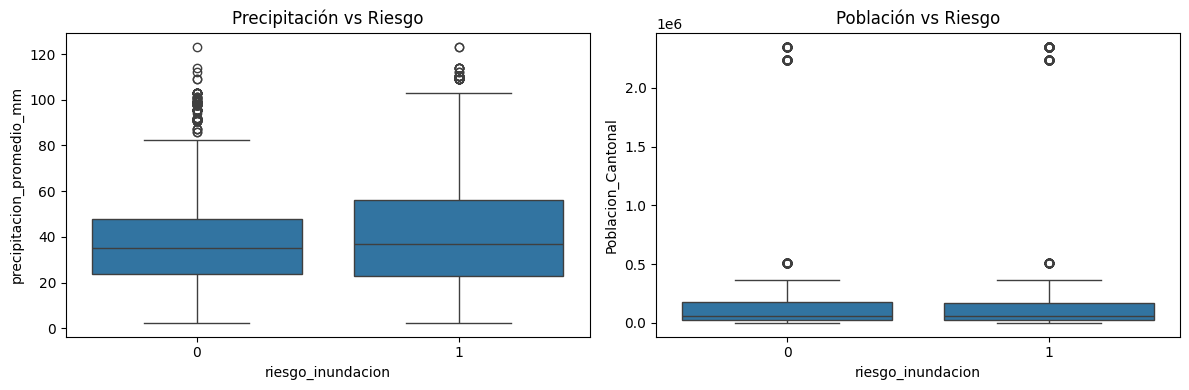

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(data=df_limpio, x='riesgo_inundacion',
            y='precipitacion_promedio_mm', ax=axs[0])
axs[0].set_title('Precipitación vs Riesgo')

sns.boxplot(data=df_limpio, x='riesgo_inundacion',
            y='Poblacion_Cantonal', ax=axs[1])
axs[1].set_title('Población vs Riesgo')

plt.tight_layout()
plt.show()

# **Distribución de variables numéricas (campana de Gauss) y Histogramas separados por clase**

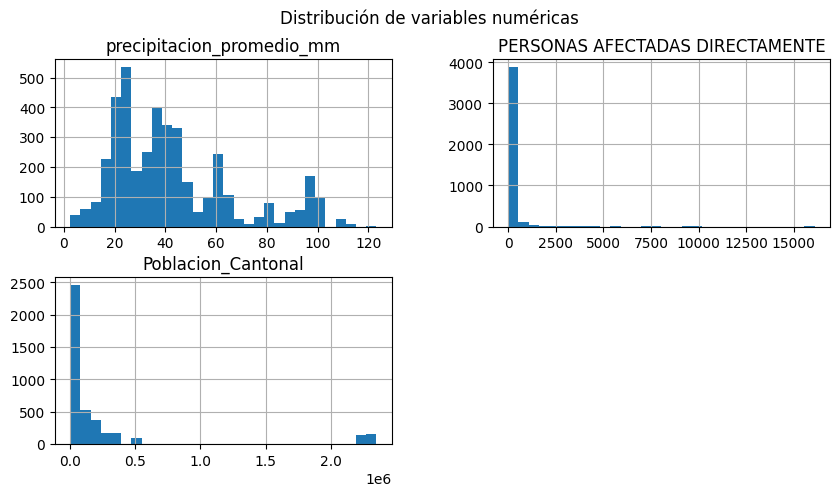

In [ ]:
df_limpio[
    ['precipitacion_promedio_mm',
     'PERSONAS AFECTADAS DIRECTAMENTE',
     'Poblacion_Cantonal']
].hist(bins=30, figsize=(10,5))

plt.suptitle("Distribución de variables numéricas")
plt.show()

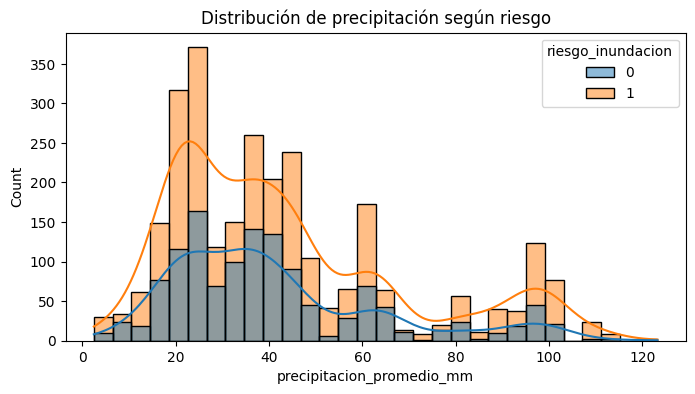

In [ ]:
plt.figure(figsize=(8,4))

sns.histplot(data=df_limpio,
             x='precipitacion_promedio_mm',
             hue='riesgo_inundacion',
             bins=30,
             kde=True)

plt.title('Distribución de precipitación según riesgo')
plt.show()

# **Scatter plots (relación entre variables)**

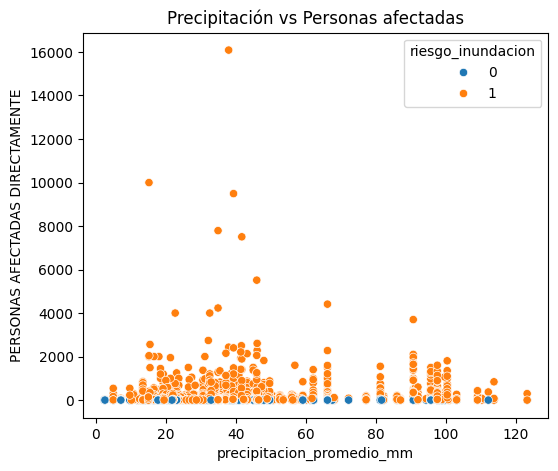

In [ ]:
plt.figure(figsize=(6,5))

sns.scatterplot(
    data=df_limpio,
    x='precipitacion_promedio_mm',
    y='PERSONAS AFECTADAS DIRECTAMENTE',
    hue='riesgo_inundacion'
)

plt.title('Precipitación vs Personas afectadas')
plt.show()

# **Correlación de variables**

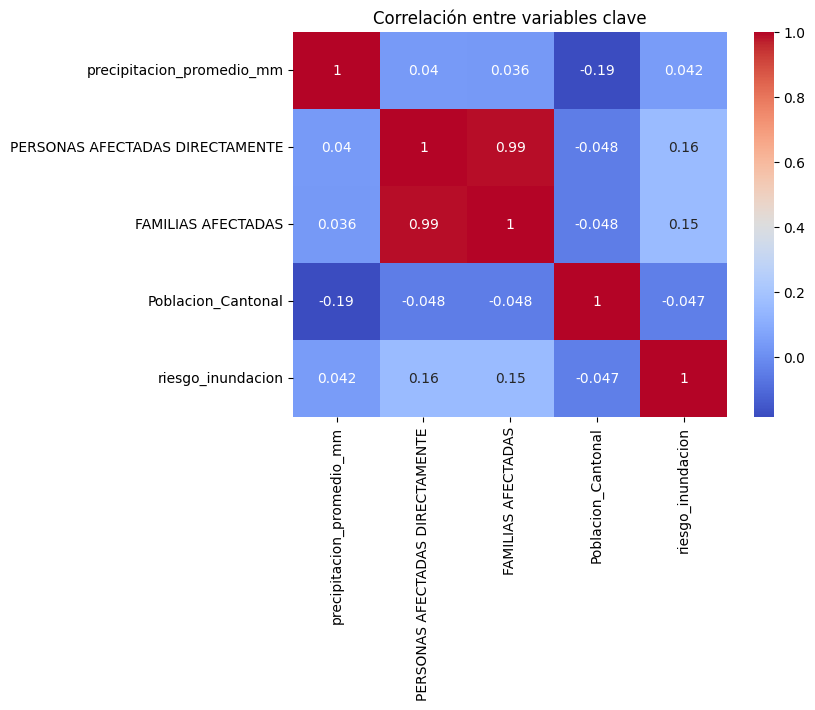

In [ ]:
vars_corr = [
    'precipitacion_promedio_mm',
    'PERSONAS AFECTADAS DIRECTAMENTE',
    'FAMILIAS AFECTADAS',
    'Poblacion_Cantonal',
    'riesgo_inundacion'
]

plt.figure(figsize=(7,5))
sns.heatmap(
    df_limpio[vars_corr].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlación entre variables clave')
plt.show()

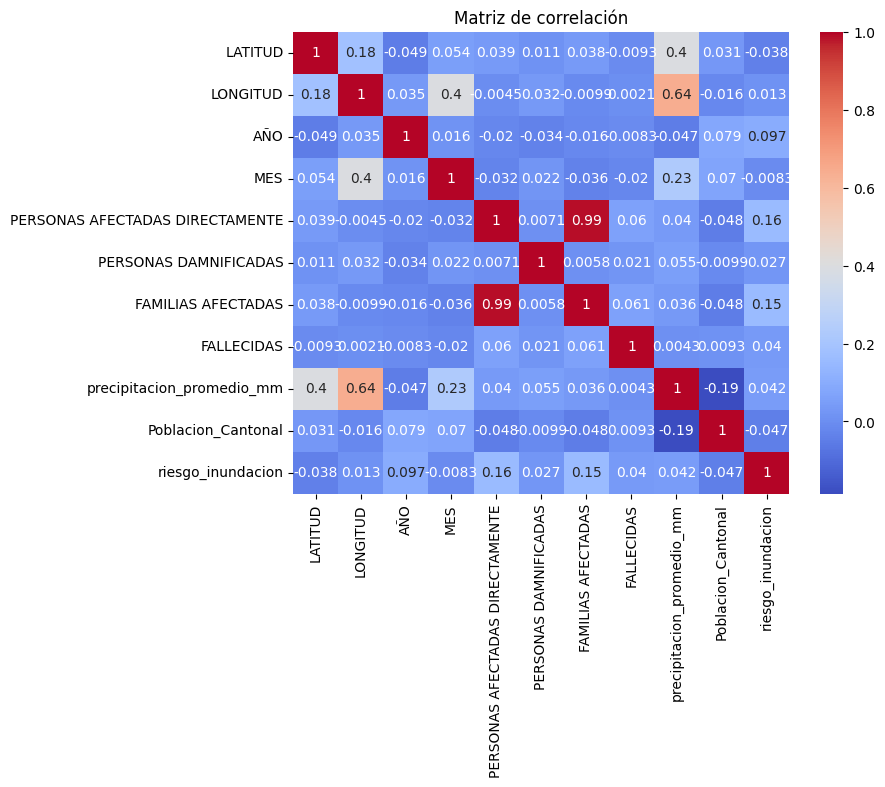

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(
    df_limpio.select_dtypes(include='number').corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Matriz de correlación")
plt.show()

Top 10

In [ ]:
top_parroquias = (
    df_limpio[df_limpio['riesgo_inundacion'] == 1]
    .groupby(['PROVINCIA', 'CANTON', 'PARROQUIAS'])
    .agg({
        'precipitacion_promedio_mm': 'mean',
        'FALLECIDAS': 'sum',
        'PERSONAS AFECTADAS DIRECTAMENTE': 'sum'
    })
    .sort_values('precipitacion_promedio_mm', ascending=False)
    .head(10)
)

top_parroquias

precipitacion_promedio_mm  \
PROVINCIA CANTON                      PARROQUIAS                                               
Pastaza   Santa Clara                 Santa Clara                                 123.241577   
Orellana  Loreto                      Loreto                                      113.762838   
                                      San Jose De Dahuano                         113.762838   
                                      Puerto Murialdo                             113.762838   
Napo      Carlos Julio Arosemena Tola Carlos Julio Arosemena Tola                 112.146168   
Sucumbíos Cascales                    Sevilla                                     110.273869   
                                      El Dorado De Cascales                       110.273869   
Pastaza   Mera                        Shell                                       109.059489   
                                      Mera                                        109.059489   
                                      Madre Tierra                                109.059489   

                                                                   FALLECIDAS  \
PROVINCIA CANTON                      PARROQUIAS                                
Pastaza   Santa Clara                 Santa Clara                         0.0   
Orellana  Loreto                      Loreto                              0.0   
                                      San Jose De Dahuano                 0.0   
                                      Puerto Murialdo                     0.0   
Napo      Carlos Julio Arosemena Tola Carlos Julio Arosemena Tola         0.0   
Sucumbíos Cascales                    Sevilla                             0.0   
                                      El Dorado De Cascales               1.0   
Pastaza   Mera                        Shell                               0.0   
                                      Mera                                1.0   
                                      Madre Tierra                        0.0   

                                                                   PERSONAS AFECTADAS DIRECTAMENTE  
PROVINCIA CANTON                      PARROQUIAS                                                    
Pastaza   Santa Clara                 Santa Clara                                            297.0  
Orellana  Loreto                      Loreto                                                   1.0  
                                      San Jose De Dahuano                                    125.0  
                                      Puerto Murialdo                                        916.0  
Napo      Carlos Julio Arosemena Tola Carlos Julio Arosemena Tola                            374.0  
Sucumbíos Cascales                    Sevilla                                                 16.0  
                                      El Dorado De Cascales                                  149.0  
Pastaza   Mera                        Shell                                                  112.0  
                                      Mera                                                   400.0  
                                      Madre Tierra                                           688.0

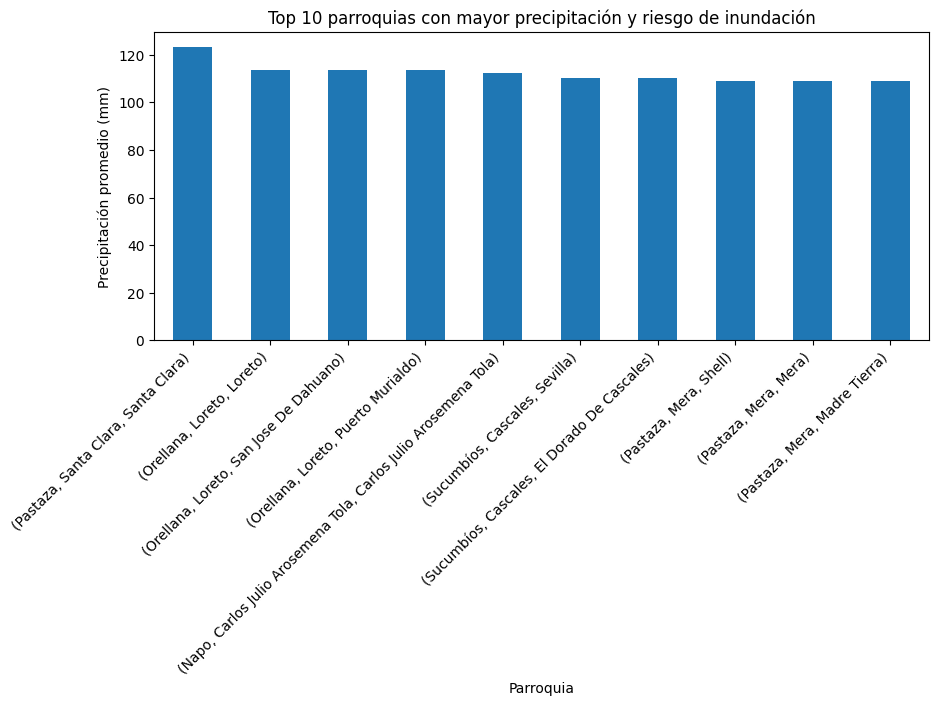

In [ ]:
top_parroquias['precipitacion_promedio_mm'].plot(
    kind='bar',
    figsize=(10,4)
)

plt.title('Top 10 parroquias con mayor precipitación y riesgo de inundación')
plt.ylabel('Precipitación promedio (mm)')
plt.xlabel('Parroquia')
plt.xticks(rotation=45, ha='right')
plt.show()

Como parte del análisis exploratorio, se realizó un análisis territorial a nivel de parroquia, identificando aquellas con mayor precipitación promedio y riesgo de inundación, así como su impacto en términos de personas afectadas y fallecidas. Este análisis permite visualizar zonas críticas y aporta contexto al posterior modelado.

El análisis exploratorio permitió verificar la correcta estructura del dataset, identificar un desbalance moderado en la variable objetivo y analizar la relación entre la precipitación, el impacto humano y el riesgo de inundación. Las visualizaciones y estadísticas descriptivas muestran diferencias relevantes entre eventos con y sin riesgo, así como la existencia de parroquias con alta precipitación y afectaciones significativas. En conjunto, los resultados confirman que el dataset contiene información pertinente y suficiente para el entrenamiento de modelos de clasificación.

In [ ]:
# Evaluación del balanceo de la variable objetivo
conteo_clases = df_limpio['riesgo_inundacion'].value_counts()
proporcion_clases = df_limpio['riesgo_inundacion'].value_counts(normalize=True)

print("Conteo de clases:")
print(conteo_clases)

print("\nProporción de clases:")
print(proporcion_clases)

Conteo de clases:
riesgo_inundacion
1    2801
0    1283
Name: count, dtype: int64

Proporción de clases:
riesgo_inundacion
1    0.685847
0    0.314153
Name: proportion, dtype: float64


# **Modelos**

Datos para modelado (X, y)

In [ ]:
# Variables predictoras (numéricas)
features = [
    'precipitacion_promedio_mm',
    'Poblacion_Cantonal',
    'LATITUD',
    'LONGITUD',
    'AÑO',
]

X = df_limpio[features]
y = df_limpio['riesgo_inundacion']

In [ ]:
print("Dimensión X:", X.shape)
print("Distribución y:")
print(y.value_counts())

Dimensión X: (4084, 5)
Distribución y:
riesgo_inundacion
1    2801
0    1283
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape[0]} muestras")
print(f"Test set: {X_test.shape[0]} muestras")
print(f"Distribución de clases en train:\n{y_train.value_counts()}")

Train set: 2858 muestras
Test set: 1226 muestras
Distribución de clases en train:
riesgo_inundacion
1    1960
0     898
Name: count, dtype: int64


In [ ]:
def evaluar_modelo(nombre, modelo, X_test, y_test, y_pred, y_prob=None):
    print(f"Evaluación: {nombre}")

    print("\nMatriz de confusión:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))

    # Gráfica 1: Matriz de confusión
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Gráfica 2: Curva ROC (si hay probabilidades)
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1], [0,1], '--')
        plt.title(f"Curva ROC - {nombre}")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend()
        plt.show()

**Regresión Logística**

In [ ]:
# Modelo base
lr_base = LogisticRegression(random_state=42, max_iter=1000)
lr_base.fit(X_train_scaled, y_train)
y_pred_lr_base = lr_base.predict(X_test_scaled)
y_proba_lr_base = lr_base.predict_proba(X_test_scaled)

print("\n--- Regresión Logística (Base) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_base):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lr_base))

# Modelo optimizado con GridSearchCV
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2']
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid_lr,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_scaled, y_train)

print(f"\nMejores parámetros: {grid_lr.best_params_}")
print(f"Mejor score (CV Recall): {grid_lr.best_score_:.3f}")

# Predicciones con modelo optimizado
y_pred_lr_opt = grid_lr.predict(X_test_scaled)
y_proba_lr_opt = grid_lr.predict_proba(X_test_scaled)

print("\nRegresión Logística (Optimizada)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_opt):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lr_opt))


--- Regresión Logística (Base) ---
Accuracy: 0.691

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.02      0.04       385
           1       0.69      1.00      0.82       841

    accuracy                           0.69      1226
   macro avg       0.78      0.51      0.43      1226
weighted avg       0.75      0.69      0.57      1226

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Mejores parámetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor score (CV Recall): 0.686

Regresión Logística (Optimizada)
Accuracy: 0.689

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       385
           1       0.69      1.00      0.82       841

    accuracy                           0.69      1226
   macro avg       0.84      0.51      0.42      1226
weighted avg       0.79      0.69      0.57      1226



COMPARACIÓN: Regresión Logística Base vs Optimizada
    Modelo  Accuracy  Precision   Recall  F1-Score
      Base  0.690865   0.747859 0.690865  0.570891
Optimizada  0.689233   0.786125 0.689233  0.565742


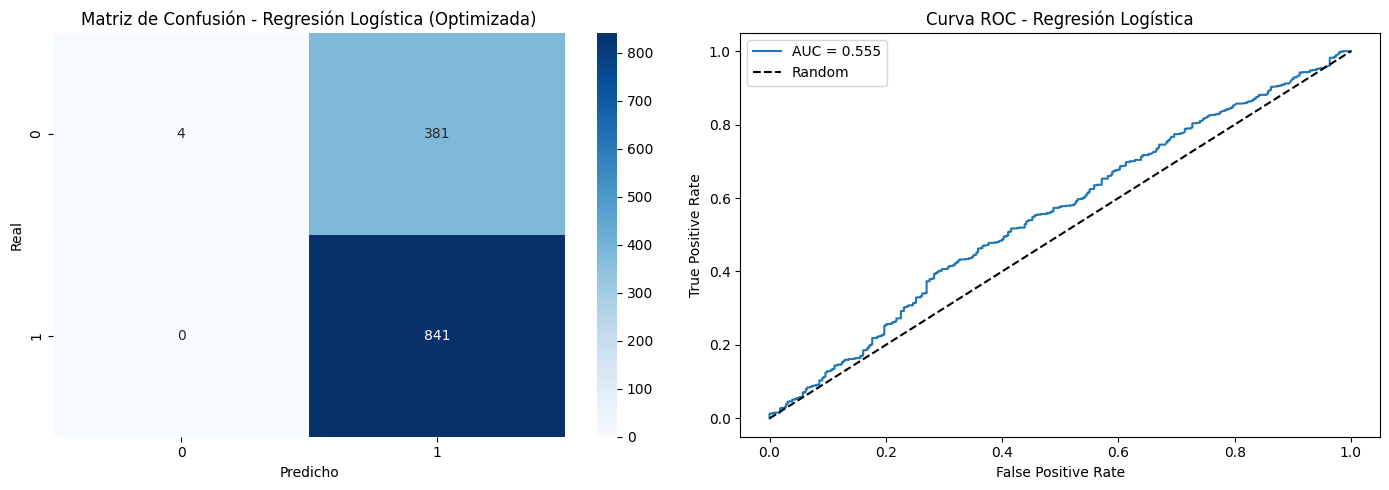

In [ ]:
#Comparación Base vs Optimizado
print("COMPARACIÓN: Regresión Logística Base vs Optimizada")

comparacion_lr = pd.DataFrame({
    'Modelo': ['Base', 'Optimizada'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr_base),
        accuracy_score(y_test, y_pred_lr_opt)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr_base, average='weighted'),
        precision_score(y_test, y_pred_lr_opt, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr_base, average='weighted'),
        recall_score(y_test, y_pred_lr_opt, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr_base, average='weighted'),
        f1_score(y_test, y_pred_lr_opt, average='weighted')
    ]
})
print(comparacion_lr.to_string(index=False))

# Gráficas de Regresión Logística
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr_opt)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Regresión Logística (Optimizada)')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')

# Curva ROC
if len(np.unique(y)) == 2:  # Solo para clasificación binaria
    fpr, tpr, _ = roc_curve(y_test, y_proba_lr_opt[:, 1])
    auc = roc_auc_score(y_test, y_proba_lr_opt[:, 1])

    axes[1].plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC - Regresión Logística')
    axes[1].legend()
else:
    # Para multi-clase, mostrar coefficients
    axes[1].barh(X.columns, grid_lr.best_estimator_.coef_[0])
    axes[1].set_title('Importancia de Features')
    axes[1].set_xlabel('Coeficiente')

plt.tight_layout()
plt.show()


**Árbol de Decisión**

In [ ]:
# Modelo base (sin poda)
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train, y_train)
y_pred_dt_base = dt_base.predict(X_test)

print("\n Árbol de Decisión (sin poda)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_base):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_dt_base))

# Modelo optimizado con GridSearchCV (pre-pruning)
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)

print(f"\nMejores parámetros (pre-pruning): {grid_dt.best_params_}")
print(f"Mejor score (CV Recall): {grid_dt.best_score_:.3f}")

# Predicciones con modelo optimizado
y_pred_dt_opt = grid_dt.predict(X_test)
y_proba_dt_opt = grid_dt.predict_proba(X_test)

print("\n Árbol de Decisión (pre-pruning)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_opt):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_dt_opt))


 Árbol de Decisión (sin poda)
Accuracy: 0.622

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.40      0.42      0.41       385
           1       0.73      0.71      0.72       841

    accuracy                           0.62      1226
   macro avg       0.57      0.57      0.57      1226
weighted avg       0.63      0.62      0.62      1226

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Mejores parámetros (pre-pruning): {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor score (CV Recall): 0.699

 Árbol de Decisión (pre-pruning)
Accuracy: 0.691

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.52      0.26      0.35       385
           1       0.72      0.89      0.80       841

    accuracy                           0.69      1226
   macro avg       0.62      0.57      0.57      1226
weighted avg       0.66      0.69

                  Modelo  Accuracy  Precision   Recall  F1-Score
         Base (sin poda)  0.622349   0.626875 0.622349  0.624500
Optimizado (pre-pruning)  0.690865   0.658402 0.690865  0.655638


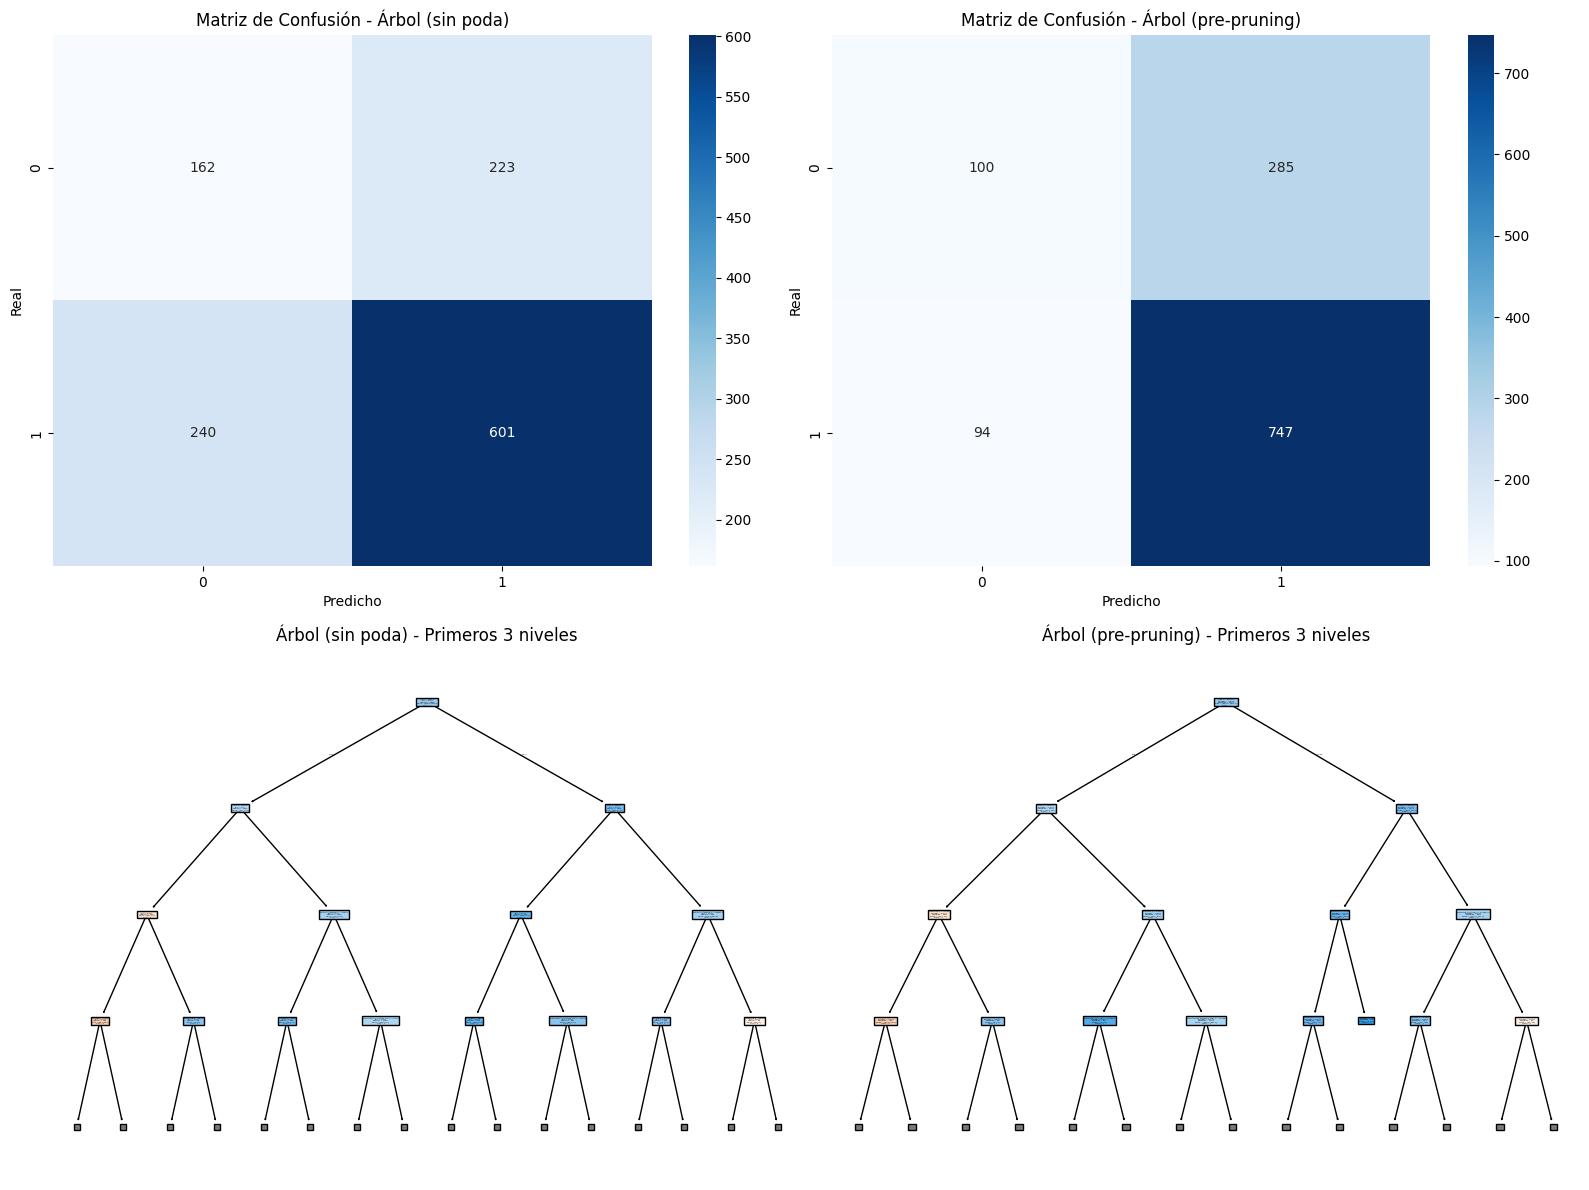

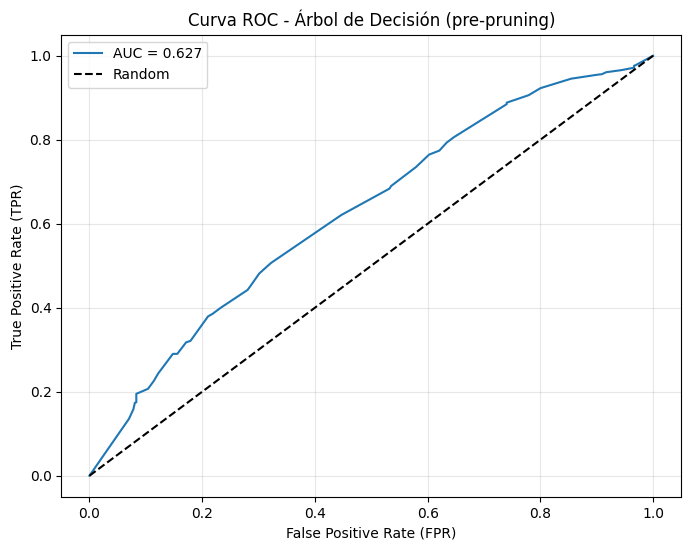

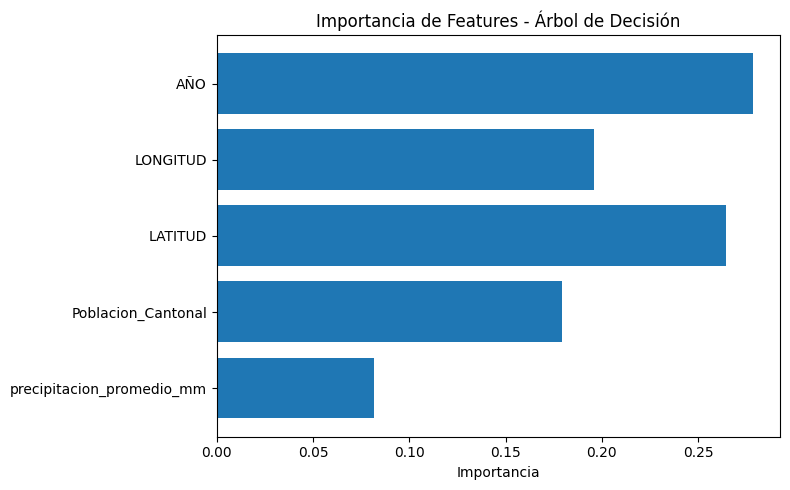

In [ ]:
comparacion_dt = pd.DataFrame({
    'Modelo': ['Base (sin poda)', 'Optimizado (pre-pruning)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt_base),
        accuracy_score(y_test, y_pred_dt_opt)
    ],
    'Precision': [
        precision_score(y_test, y_pred_dt_base, average='weighted'),
        precision_score(y_test, y_pred_dt_opt, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt_base, average='weighted'),
        recall_score(y_test, y_pred_dt_opt, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_dt_base, average='weighted'),
        f1_score(y_test, y_pred_dt_opt, average='weighted')
    ]
})
print(comparacion_dt.to_string(index=False))

# Gráficas del Árbol de Decisión
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Matriz de confusión - Base
cm_dt_base = confusion_matrix(y_test, y_pred_dt_base)
sns.heatmap(cm_dt_base, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Matriz de Confusión - Árbol (sin poda)')
axes[0, 0].set_ylabel('Real')
axes[0, 0].set_xlabel('Predicho')

# Matriz de confusión - Optimizado
cm_dt_opt = confusion_matrix(y_test, y_pred_dt_opt)
sns.heatmap(cm_dt_opt, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Matriz de Confusión - Árbol (pre-pruning)')
axes[0, 1].set_ylabel('Real')
axes[0, 1].set_xlabel('Predicho')

# Árbol base (primeros 3 niveles)
plot_tree(dt_base,
          max_depth=3,
          filled=True,
          feature_names=X.columns,
          class_names=[str(c) for c in np.unique(y)],
          ax=axes[1, 0])
axes[1, 0].set_title('Árbol (sin poda) - Primeros 3 niveles')

# Árbol optimizado (primeros 3 niveles)
plot_tree(grid_dt.best_estimator_,
          max_depth=3,
          filled=True,
          feature_names=X.columns,
          class_names=[str(c) for c in np.unique(y)],
          ax=axes[1, 1])
axes[1, 1].set_title('Árbol (pre-pruning) - Primeros 3 niveles')

plt.tight_layout()
plt.show()

# Curva ROC para árbol optimizado
if len(np.unique(y)) == 2:
    plt.figure(figsize=(8, 6))
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt_opt[:, 1])
    auc_dt = roc_auc_score(y_test, y_proba_dt_opt[:, 1])

    plt.plot(fpr_dt, tpr_dt, label=f'AUC = {auc_dt:.3f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Curva ROC - Árbol de Decisión (pre-pruning)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Feature importance
importances = grid_dt.best_estimator_.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(X.columns, importances)
plt.xlabel('Importancia')
plt.title('Importancia de Features - Árbol de Decisión')
plt.tight_layout()
plt.show()

Modelos Guardados para Ensamble

In [ ]:
# Elegir mejor para ensamble
if recall_score(y_test, y_pred_lr_base, average='weighted') > \
   recall_score(y_test, y_pred_lr_opt, average='weighted'):
    mejor_lr = lr_base
    print("mejor_lr: RL Base (mejor Recall)")
else:
    mejor_lr = grid_lr.best_estimator_
    print("mejor_rl: RL Optimizada")
if recall_score(y_test, y_pred_dt_base, average='weighted') > \
   recall_score(y_test, y_pred_dt_opt, average='weighted'):
    mejor_dt = dt_base
    print("mejor_dt: DT Base (mejor Recall)")
else:
    mejor_dt = grid_dt.best_estimator_
    print("mejor_dt: DT Optimizado")

mejor_lr: RL Base (mejor Recall)
mejor_dt: DT Optimizado


In [ ]:
print("MODELOS SELECCIONADOS PARA ENSAMBLE")
print(f"RL: {'Base' if mejor_lr == lr_base else 'Optimizada'}")
print(f"DT: {'Base' if mejor_dt == dt_base else 'Optimizado'}")

MODELOS SELECCIONADOS PARA ENSAMBLE
RL: Base
DT: Optimizado


Resumen de Resultados

In [ ]:
resumen_final = pd.DataFrame({
    'Modelo': [
        'Regresión Logística (Base)',
        'Regresión Logística (Optimizada)',
        'Árbol de Decisión (Base)',
        'Árbol de Decisión (Optimizado)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr_base),
        accuracy_score(y_test, y_pred_lr_opt),
        accuracy_score(y_test, y_pred_dt_base),
        accuracy_score(y_test, y_pred_dt_opt)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr_base, average='weighted'),
        precision_score(y_test, y_pred_lr_opt, average='weighted'),
        precision_score(y_test, y_pred_dt_base, average='weighted'),
        precision_score(y_test, y_pred_dt_opt, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr_base, average='weighted'),
        recall_score(y_test, y_pred_lr_opt, average='weighted'),
        recall_score(y_test, y_pred_dt_base, average='weighted'),
        recall_score(y_test, y_pred_dt_opt, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr_base, average='weighted'),
        f1_score(y_test, y_pred_lr_opt, average='weighted'),
        f1_score(y_test, y_pred_dt_base, average='weighted'),
        f1_score(y_test, y_pred_dt_opt, average='weighted')
    ]
})

print(resumen_final.to_string(index=False))

# Identificar mejor modelo por Recall
mejor_idx = resumen_final['Recall'].idxmax()
print(f"\nMejor modelo (por Recall): {resumen_final.loc[mejor_idx, 'Modelo']}")
print(f"Recall: {resumen_final.loc[mejor_idx, 'Recall']:.3f}")

                          Modelo  Accuracy  Precision   Recall  F1-Score
      Regresión Logística (Base)  0.690865   0.747859 0.690865  0.570891
Regresión Logística (Optimizada)  0.689233   0.786125 0.689233  0.565742
        Árbol de Decisión (Base)  0.622349   0.626875 0.622349  0.624500
  Árbol de Decisión (Optimizado)  0.690865   0.658402 0.690865  0.655638

Mejor modelo (por Recall): Regresión Logística (Base)
Recall: 0.691


MODELO AVANZADO, OPTIMIZACIÓN Y MÉTRICAS

In [ ]:
# Configuración de hiperparámetros
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Usamos GridSearchCV
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_scaled, y_train)

best_rf_model = grid_rf.best_estimator_

print(f"Mejores parámetros RF: {grid_rf.best_params_}")
print(f"Mejor Recall (Weighted) en CV: {grid_rf.best_score_:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros RF: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mejor Recall (Weighted) en CV: 0.7054


In [ ]:
y_pred_rf = best_rf_model.predict(X_test_scaled)
y_prob_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Desempeño Random Forest en Test ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"AUC:       {roc_auc_score(y_test, y_prob_rf):.4f}")


--- Desempeño Random Forest en Test ---
Accuracy:  0.7104
Precision: 0.6873
Recall:    0.7104
F1-Score:  0.6606
AUC:       0.6955


In [ ]:
final_lr = mejor_lr
final_dt = mejor_dt
final_rf = best_rf_model     # Random Forest optimizado (GridSearch)

# Creamos el Ensamble
voting_clf = VotingClassifier(
    estimators=[
        ('lr', final_lr),
        ('dt', final_dt),
        ('rf', final_rf)
    ],
    voting='soft'  # Necesario para AUC y ROC
)

# Entrenamos el ensamble
voting_clf.fit(X_train_scaled, y_train)

# Predicciones del Ensamble
y_pred_vote = voting_clf.predict(X_test_scaled)
y_prob_vote = voting_clf.predict_proba(X_test_scaled)[:, 1]

print("Ensamble entrenado exitosamente.")

Ensamble entrenado exitosamente.


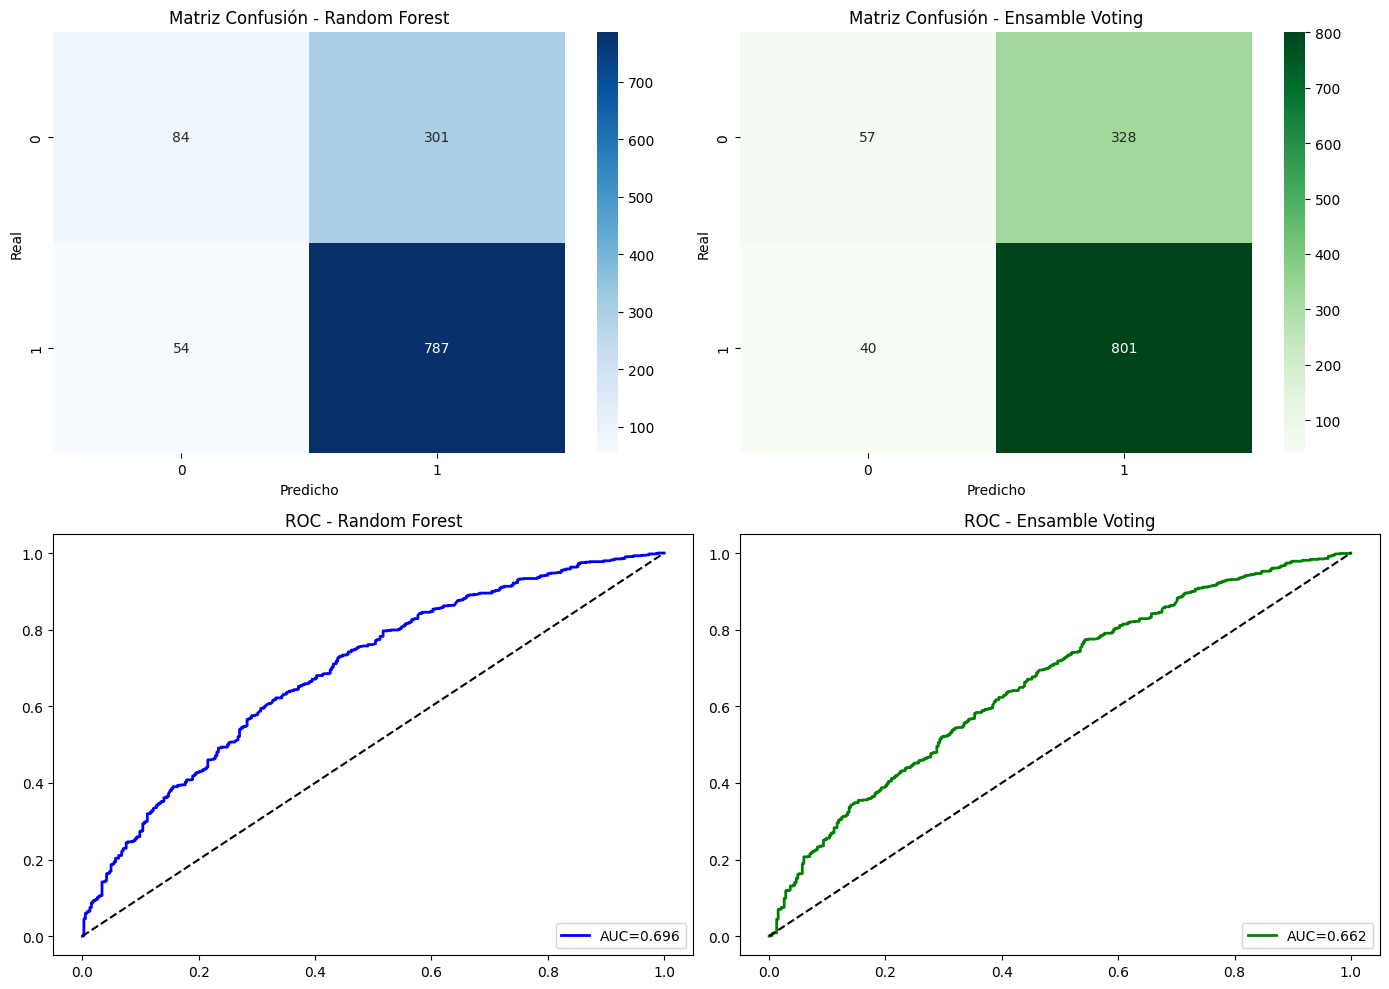

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Matriz Confusión RF
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Matriz Confusión - Random Forest')
axes[0,0].set_ylabel('Real'); axes[0,0].set_xlabel('Predicho')

# Matriz Confusión Voting
sns.heatmap(confusion_matrix(y_test, y_pred_vote), annot=True, fmt='d', cmap='Greens', ax=axes[0,1])
axes[0,1].set_title('Matriz Confusión - Ensamble Voting')
axes[0,1].set_ylabel('Real'); axes[0,1].set_xlabel('Predicho')

# ROC Curve RF
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
axes[1,0].plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'AUC={roc_auc_score(y_test, y_prob_rf):.3f}')
axes[1,0].plot([0, 1], [0, 1], 'k--')
axes[1,0].set_title('ROC - Random Forest')
axes[1,0].legend(loc="lower right")

# ROC Curve Voting
fpr_v, tpr_v, _ = roc_curve(y_test, y_prob_vote)
axes[1,1].plot(fpr_v, tpr_v, color='green', lw=2, label=f'AUC={roc_auc_score(y_test, y_prob_vote):.3f}')
axes[1,1].plot([0, 1], [0, 1], 'k--')
axes[1,1].set_title('ROC - Ensamble Voting')
axes[1,1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
def get_metrics(model_name, y_true, y_pred, y_prob=None):
    res = {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (W)': precision_score(y_true, y_pred, average='weighted'),
        'Recall (W)': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score (W)': f1_score(y_true, y_pred, average='weighted')
    }
    if y_prob is not None:
        try:
            res['AUC'] = roc_auc_score(y_true, y_prob)
        except ValueError:
            res['AUC'] = 0.0
    else:
        res['AUC'] = 0.0
    return res

In [ ]:
resultados = []

# Regresión Logística
y_pred_lr = mejor_lr.predict(X_test_scaled)
y_prob_lr = mejor_lr.predict_proba(X_test_scaled)[:, 1]

resultados.append(
    get_metrics(
        'Regresión Logística',
        y_test,
        y_pred_lr,
        y_prob_lr
    )
)

# Árbol de Decisión
y_pred_dt = mejor_dt.predict(X_test)
y_prob_dt = mejor_dt.predict_proba(X_test)[:, 1]

resultados.append(
    get_metrics(
        'Árbol de Decisión',
        y_test,
        y_pred_dt,
        y_prob_dt
    )
)

# Random Forest
resultados.append(
    get_metrics(
        'Random Forest',
        y_test,
        y_pred_rf,
        y_prob_rf
    )
)

# Ensamble Voting
resultados.append(
    get_metrics(
        'Ensamble (Voting)',
        y_test,
        y_pred_vote,
        y_prob_vote
    )
)

df_resumen = pd.DataFrame(resultados).set_index('Modelo')
print("\n=== TABLA COMPARATIVA FINAL DE MÉTRICAS ===")
print(df_resumen.round(4))


=== TABLA COMPARATIVA FINAL DE MÉTRICAS ===
                     Accuracy  Precision (W)  Recall (W)  F1-Score (W)     AUC
Modelo                                                                        
Regresión Logística    0.6909         0.7479      0.6909        0.5709  0.5573
Árbol de Decisión      0.6909         0.6584      0.6909        0.6556  0.6268
Random Forest          0.7104         0.6873      0.7104        0.6606  0.6955
Ensamble (Voting)      0.6998         0.6712      0.6998        0.6321  0.6624


En el contexto de predicción de riesgo de inundación, el **Recall (Sensibilidad)**
es la métrica más importante porque:

1. **Falsos Negativos son costosos:** No identificar una parroquia en riesgo (FN)
   puede resultar en pérdidas humanas y materiales.

2. **Falsos Positivos son tolerables:** Marcar una parroquia como riesgo cuando
   no lo está (FP) solo genera alertas preventivas, lo cual es preferible.

3. **Objetivo del modelo:** Capturar la MÁXIMA cantidad de casos de riesgo real,
   aunque esto signifique algunas falsas alarmas.

Por tanto, priorizamos **maximizar Recall** sobre Precision.

In [ ]:
modelo_final = best_rf_model
X_eval = X_test_scaled
usa_prob = True

# Predicciones finales
y_pred_final = modelo_final.predict(X_eval)
y_prob_final = modelo_final.predict_proba(X_eval)[:, 1] if usa_prob else None

# DataFrame para exportacion
df_export = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred_final
})

if y_prob_final is not None:
    df_export["y_prob"] = y_prob_final

# Exportar a CSV
output_path = "predicciones_modelo_final.csv"
df_export.to_csv(output_path, index=False)
print(f"\nPredicciones exportadas a: {output_path}")


Predicciones exportadas a: predicciones_modelo_final.csv


#**Arbol de decision vs Regresion Logistica**

Ambos modelos presentan la misma Accuracy (0.6909), pero difieren en su capacidad para identificar correctamente los casos de riesgo. La Regresión Logística tiene una Precisión alta (0.7479), pero su Recall es 0.6909 y su AUC es bajo (0.5573), lo que indica dificultades para detectar todos los eventos de riesgo.
El Árbol de Decisión alcanza el mismo Recall (0.6909), pero con un AUC mayor (0.6268) y un F1-Score superior (0.6556), mostrando un comportamiento más equilibrado y una mejor capacidad de discriminación entre clases, lo que lo hace más adecuado en un contexto de riesgo.

#**Random Forest vs Ensamble**

Al comparar el Random Forest con el Ensamble, se observa que el Random Forest presenta el mejor desempeño en la métrica prioritaria del proyecto, el Recall, alcanzando un valor de 0.7104, superior al obtenido por el Ensamble (0.6998). Esto indica que el Random Forest identifica una mayor proporción de parroquias en riesgo, reduciendo de forma más efectiva los falsos negativos, que son críticos en escenarios de gestión de inundaciones.

Adicionalmente, el Random Forest obtiene el AUC más alto (0.6955), lo que evidencia una mejor capacidad de discriminación entre clases frente al Ensamble (0.6624). Aunque el Ensamble combina varios modelos, su F1-Score (0.6321) es inferior al del Random Forest (0.6606), lo que sugiere que la combinación no logró optimizar el equilibrio entre precisión y sensibilidad.

En conjunto, los resultados muestran que el Random Forest ofrece un desempeño más robusto y consistente que el Ensamble, siendo más eficaz para detectar eventos de riesgo sin sacrificar estabilidad en las métricas, lo que lo consolida como la mejor alternativa para el objetivo del proyecto.

#**Conclusiones**

Selección del Modelo Final y Prioridad del Recall:

En la gestión de riesgo de inundaciones, la métrica prioritaria es el Recall, ya que los falsos negativos (no detectar una parroquia en riesgo real) tienen consecuencias graves en términos de vidas humanas y daños materiales.
Los falsos positivos, en cambio, solo implican medidas preventivas adicionales.

El Random Forest presenta el mayor Recall (0.7104) entre todos los modelos evaluados, lo que significa que detecta la mayor proporción de eventos de riesgo reales.
Este desempeño, junto con su AUC elevado y un F1-Score equilibrado, lo convierte en el modelo más confiable para un sistema de alerta temprana.

El Random Forest optimizado es el modelo recomendado, ya que prioriza correctamente el Recall, minimiza los falsos negativos y mantiene un buen equilibrio con las demás métricas.
Accuracy, F1-Score y AUC se utilizan como métricas de soporte, pero la decisión final se fundamenta en el Recall, en concordancia con los objetivos de la gestión de riesgo.

In [ ]:
df_export = pd.DataFrame({
    "dpa_parroquia": df_limpio.loc[y_test.index, 'CODIFICACION PARROQUIAL'],
    "y_true": y_test.values,
    "y_pred": y_pred_final,
    "y_prob": y_prob_final
})

df_export.to_csv("predicciones_modelo_final_con_id.csv", index=False)

In [ ]:
import os
import shutil
import requests
from flask import Flask, render_template_string, send_from_directory
from google.colab.output import eval_js

# Identificadores de tus archivos en Google Drive
ID_JSON_DRIVE = '1u8uvcR8Mf5U3bXqbu8Qv2wiKJuhilCbJ'
ID_CSV_DRIVE = '1oBLdLOrhf78O67jmmSOu_45UZg1LWtFK'

# Nombres exactos de los archivos
NOMBRE_JSON = 'ORGANIZACION TERRITORIAL DEL ESTADO PARROQUIAL (1).json'
NOMBRE_CSV = 'predicciones_modelo_final_con_id.csv'

def descargar_de_drive(file_id, output_path):
    url = f'https://drive.google.com/uc?export=download&id={file_id}'
    response = requests.get(url)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            f.write(response.content)
        print(f"Archivo listo: {output_path}")
    else:
        print(f"Error al descargar el archivo: {file_id}")

# Preparar carpetas y descargar archivos
os.makedirs('static', exist_ok=True)
descargar_de_drive(ID_JSON_DRIVE, f'static/{NOMBRE_JSON}')
descargar_de_drive(ID_CSV_DRIVE, f'static/{NOMBRE_CSV}')

# HTML con Triple Selector Jerarquico
html_maestro = """
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>Mapa de Riesgo Ecuador</title>
    <link rel="stylesheet" href="https://unpkg.com/leaflet@1.9.4/dist/leaflet.css" />
    <style>
        body { margin: 0; font-family: 'Segoe UI', Tahoma, sans-serif; background: #f0f2f5; }
        .header { background: #001f3f; color: white; padding: 10px; text-align: center; }
        .controls {
            display: flex;
            flex-wrap: wrap;
            gap: 15px;
            padding: 15px;
            background: white;
            justify-content: center;
            align-items: center;
            border-bottom: 2px solid #ddd;
        }
        select, input { padding: 10px; border-radius: 5px; border: 1px solid #ccc; width: 200px; font-size: 14px; }
        #map { height: 80vh; width: 100%; }
        .legend { background: white; padding: 10px; border-radius: 5px; box-shadow: 0 0 10px rgba(0,0,0,0.2); line-height: 18px; }
        .legend i { width: 18px; height: 18px; float: left; margin-right: 8px; opacity: 0.8; }
    </style>
</head>
<body>
    <div class="header"><h2 style="margin:0;">Analisis de Riesgo por Parroquia</h2></div>

    <div class="controls">
        <select id="prov"><option value="">Provincia...</option></select>
        <select id="can" disabled><option value="">Canton...</option></select>
        <select id="par" disabled><option value="">Parroquia...</option></select>
        <button onclick="location.reload()" style="padding: 10px; cursor: pointer; background: #f8f9fa; border: 1px solid #ddd; border-radius: 5px;">Reiniciar Mapa</button>
    </div>

    <div id="map"></div>

    <script src="https://unpkg.com/leaflet@1.9.4/dist/leaflet.js"></script>
    <script>
        var map = L.map('map').setView([-1.83, -78.18], 7);
        L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png').addTo(map);

        var geoLayer, riskData = {};

        function getColor(d) {
            return d > 0.8 ? '#800026' : d > 0.6 ? '#BD0026' : d > 0.4 ? '#E31A1C' :
                   d > 0.2 ? '#FC4E2A' : d > 0.05 ? '#FD8D3C' : '#FFEDA0';
        }

        const urlJson = encodeURI('/static/{{NOMBRE_JSON}}');
        const urlCsv = encodeURI('/static/{{NOMBRE_CSV}}');

        Promise.all([
            fetch(urlJson).then(r => r.json()),
            fetch(urlCsv).then(r => r.text())
        ]).then(([geojsonData, csvText]) => {

            // Procesar CSV y corregir IDs (Fix Guayaquil)
            csvText.split('\\n').slice(1).forEach(row => {
                var cols = row.split(',');
                if(cols.length >= 4) {
                    var id = cols[0].trim().padStart(6, '0');
                    riskData[id] = parseFloat(cols[3]);
                }
            });

            geoLayer = L.geoJson(geojsonData, {
                style: (f) => ({
                    fillColor: getColor(riskData[f.properties.DPA_PARROQ] || 0),
                    weight: 0.6, opacity: 1, color: 'white', fillOpacity: 0.7
                }),
                onEachFeature: (f, l) => {
                    var p = riskData[f.properties.DPA_PARROQ] || 0;
                    var contenido = '<div style="font-size:13px;">' +
                        '<b style="color:#001f3f;">' + f.properties.DPA_DESPAR + '</b><br>' +
                        '<b>Provincia:</b> ' + f.properties.DPA_DESPRO + '<br>' +
                        '<b>Canton:</b> ' + f.properties.DPA_DESCAN + '<br>' +
                        '<hr style="border:0; border-top:1px solid #eee;">' +
                        '<b>Riesgo:</b> ' + (p * 100).toFixed(2) + '%' +
                        '</div>';
                    l.bindPopup(contenido);
                }
            }).addTo(map);

            const selProv = document.getElementById('prov');
            const selCan = document.getElementById('can');
            const selPar = document.getElementById('par');

            // Cargar Provincias
            const provincias = [...new Set(geojsonData.features.map(f => f.properties.DPA_DESPRO))].sort();
            provincias.forEach(p => selProv.add(new Option(p, p)));

            // Evento Provincia -> Cargar Cantones
            selProv.onchange = () => {
                selCan.innerHTML = '<option value="">Canton...</option>';
                selPar.innerHTML = '<option value="">Parroquia...</option>';
                selCan.disabled = !selProv.value;
                selPar.disabled = true;

                if (selProv.value) {
                    const filtered = geojsonData.features.filter(f => f.properties.DPA_DESPRO === selProv.value);
                    const cantones = [...new Set(filtered.map(f => f.properties.DPA_DESCAN))].sort();
                    cantones.forEach(c => selCan.add(new Option(c, c)));
                    map.fitBounds(L.geoJson(filtered).getBounds());
                }
            };

            // Evento Canton -> Cargar Parroquias
            selCan.onchange = () => {
                selPar.innerHTML = '<option value="">Parroquia...</option>';
                selPar.disabled = !selCan.value;

                if (selCan.value) {
                    const filtered = geojsonData.features.filter(f =>
                        f.properties.DPA_DESPRO === selProv.value &&
                        f.properties.DPA_DESCAN === selCan.value
                    );
                    filtered.sort((a,b) => a.properties.DPA_DESPAR.localeCompare(b.properties.DPA_DESPAR))
                            .forEach(f => selPar.add(new Option(f.properties.DPA_DESPAR, f.properties.DPA_PARROQ)));
                    map.fitBounds(L.geoJson(filtered).getBounds());
                }
            };

            // Evento Parroquia -> Zoom Final
            selPar.onchange = () => {
                geoLayer.eachLayer(l => {
                    if(l.feature.properties.DPA_PARROQ === selPar.value) {
                        map.fitBounds(l.getBounds());
                        l.openPopup();
                    }
                });
            };
        });
    </script>
</body>
</html>
"""

# Reemplazo manual de nombres
html_maestro = html_maestro.replace("{{NOMBRE_JSON}}", NOMBRE_JSON).replace("{{NOMBRE_CSV}}", NOMBRE_CSV)

app = Flask(__name__)
@app.route('/')
def home(): return render_template_string(html_maestro)

@app.route('/static/<path:filename>')
def serve_static(filename): return send_from_directory('static', filename)

if __name__ == '__main__':
    # Si el link no funciona o sale error de conexion, cambia el 5000 por 5001 o 8080 en las dos lineas de abajo
    url = eval_js("google.colab.kernel.proxyPort(5000)") # <--- CAMBIAR AQUI
    print(f"Link del mapa: {url.strip()}")
    app.run(port=5000) # <--- CAMBIAR AQUI TAMBIEN (debe ser el mismo numero)

Archivo listo: static/ORGANIZACION TERRITORIAL DEL ESTADO PARROQUIAL (1).json
Archivo listo: static/predicciones_modelo_final_con_id.csv
Link del mapa: https://5000-m-s-2certnakghwxi-a.us-east4-1.prod.colab.dev
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


**Resumen del Proyecto: Mapa de Riesgo de Inundaciones (Ecuador)**

**1. Visualización Geoespacial e Interfaz**
Se creó una aplicación web interactiva con Flask (Python) y Leaflet.js (JavaScript) para visualizar la probabilidad de inundación en el área parroquial.


Buscador Jerárquico: Implementación de un menú desplegable en cascada (Provincia > Cantón > Parroquia) que filtra los datos en tiempo real e implementa el zoom automático del área seleccionada.


Búsqueda Predictiva: Barra de búsqueda que permite encontrar las parroquias por nombre sin la necesidad de saber antes la provincia.


Popups Detallados: Etiquetas informativas que muestran la jerarquía completa (Provincia y Cantón) y el porcentaje de riesgo exacto al clicar en cualquiera de los polígonos.


Leyenda Dinámica: Escala de colores (Heatmap) referidos a la probabilidad del modelo, desde el amarillo (bajo riesgo) al rojo oscuro (alto riesgo).





**2. Gestión y Persistencia de Datos**
Mejoramos cómo la aplicación maneja la información para que sea un sistema robusto y fácil de compartir.


Integración Google Drive: Migramos los archivos locales a la nube. El sistema ahora baja automáticamente el archivo GeoJSON de organización territorial y el CSV de predicciones a través de enlaces públicos de Drive, eliminando la necesidad subir archivos manualmente cada vez que se reinicia .

**3. Infraestructura de servidor (Flask en Colab)**
He superado las limitaciones técnicas que presentan la ejecución de servidores web en un entorno de nube temporal.
Túneles de puertos: Configuración de múltiple puertos (5000, 8000, 8888, etc.) para prevenir bloqueos por sesión de Google Colab.
Renderizado de plantillas: Uso de render_template_string para inyectar directamente el código HTML/JS desde Python y de esta forma evitar errores de rutas (Not Found).
Seguridad de sintaxis: Resolución de conflictos entre las llaves {} de Python (f-strings) y las de JavaScript para permitir popups dinámicos sin errores de compilación.
